In [6]:

import os
import torch
import pandas as pd
import pickle
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score




In [7]:

from transformers import VideoMAEFeatureExtractor, VideoMAEForVideoClassification
from decord import VideoReader, cpu

/storage/home/hcoda1/3/ryendapalli3/.conda/envs/exist2025/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
from torch.optim import AdamW







In [9]:
class TikTokVideoDataset(Dataset):
    def __init__(self, df, video_dir, feature_extractor, num_frames=16):
        self.video_dir = video_dir
        self.feature_extractor = feature_extractor
        self.num_frames = num_frames
        self.valid_rows = []

        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking videos"):
            video_path = os.path.join(video_dir, row['video'])
            try:
                vr = VideoReader(video_path, ctx=cpu(0))
                if len(vr) >= num_frames:
                    self.valid_rows.append(row)
            except:
                continue

        self.df = pd.DataFrame(self.valid_rows).reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_path = os.path.join(self.video_dir, row['video'])
        try:
            vr = VideoReader(video_path, ctx=cpu(0))
            total_frames = len(vr)
            indices = torch.linspace(0, total_frames - 1, self.num_frames).long().tolist()
            video = vr.get_batch(indices).asnumpy()
            inputs = self.feature_extractor([frame for frame in video], return_tensors="pt")
            pixel_values = inputs["pixel_values"].squeeze(0)
            label = int(row['target'])
            return {"pixel_values": pixel_values, "labels": torch.tensor(label)}
        except:
            return None

def skip_none_collate(batch):
    batch = [x for x in batch if x is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.default_collate(batch)

In [10]:
test_path = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/train_test/test_df.csv"
val_path = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/train_test/valid_df.csv"
train_path = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/train_test/train_df.csv"
video_dir = "/storage/coda1/p-dsgt_clef2025/0/shared/exist/latest/EXIST_2025_Videos_Dataset/training/videos"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

feature_extractor = VideoMAEFeatureExtractor.from_pretrained("MCG-NJU/videomae-base")

/storage/home/hcoda1/3/ryendapalli3/.conda/envs/exist2025/lib/python3.12/site-packages/transformers/models/videomae/feature_extraction_videomae.py:28: FutureWarning: The class VideoMAEFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use VideoMAEImageProcessor instead.
  warnings.warn(


In [11]:
def get_or_create_dataset(cache_file, df, video_dir, feature_extractor, num_frames=16):
    if os.path.exists(cache_file):
        print(f"Loading cached dataset: {cache_file}")
        with open(cache_file, "rb") as f:
            return pickle.load(f)
    else:
        print(f"Building and caching dataset: {cache_file}")
        dataset = TikTokVideoDataset(df, video_dir, feature_extractor, num_frames)
        with open(cache_file, "wb") as f:
            pickle.dump(dataset, f)
        return dataset

train_dataset = get_or_create_dataset("cached_train_dataset.pkl", train_df, video_dir, feature_extractor)
val_dataset = get_or_create_dataset("cached_val_dataset.pkl", val_df, video_dir, feature_extractor)
test_dataset = get_or_create_dataset("cached_test_dataset.pkl", test_df, video_dir, feature_extractor)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=8,
                          pin_memory=True, prefetch_factor=2, collate_fn=skip_none_collate, persistent_workers=True)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=8,
                          pin_memory=True, prefetch_factor=2, collate_fn=skip_none_collate, persistent_workers=True)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=8,
                         pin_memory=True, prefetch_factor=2, collate_fn=skip_none_collate, persistent_workers=True)


Loading cached dataset: cached_train_dataset.pkl
Loading cached dataset: cached_val_dataset.pkl
Loading cached dataset: cached_test_dataset.pkl


In [12]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            if batch is None:
                continue
            inputs = batch["pixel_values"].to(model.device)
            labels = batch["labels"].to(model.device)

            outputs = model(pixel_values=inputs)
            loss = torch.nn.CrossEntropyLoss()(outputs.logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    avg_loss = total_loss / len(data_loader)
    return avg_loss, acc, f1


In [13]:
import copy
import csv

def run_experiment(freeze_type, lr, dropout, trial_name):
    print(f"\nRunning {trial_name} | freeze={freeze_type}, lr={lr}, dropout={dropout}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base", num_labels=2)

    if freeze_type == "all":
        for param in model.videomae.parameters():
            param.requires_grad = False
    elif freeze_type == "last3":
        for param in model.videomae.parameters():
            param.requires_grad = False
        for block in model.videomae.encoder.layer[-3:]:
            for param in block.parameters():
                param.requires_grad = True
    elif freeze_type == "none":
        for param in model.videomae.parameters():
            param.requires_grad = True


    import torch.nn as nn
    model.dropout = nn.Dropout(dropout)
    original_forward = model.forward
    def patched_forward(*args, **kwargs):
        out = original_forward(*args, **kwargs)
        out.logits = model.dropout(out.logits)
        return out
    model.forward = patched_forward

    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    best_f1 = 0
    patience = 3
    wait = 0

    for epoch in range(10):
        model.train()
        train_preds, train_labels = [], []
        total_train_loss = 0

        for batch in train_loader:
            if batch is None:
                continue
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(pixel_values=inputs)
            loss = criterion(outputs.logits, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_acc = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average="macro")
        train_loss_avg = total_train_loss / len(train_loader)

        test_loss, test_acc, test_f1 = evaluate_model(model, test_loader)

        print(
            f"Epoch {epoch+1}: "
            f"Train Loss = {train_loss_avg:.4f}, Train Acc = {train_acc:.4f}, "
            f"Test Loss = {test_loss:.4f}, Test Acc = {test_acc:.4f}, F1 Macro = {test_f1:.4f}"
        )

        if test_f1 > best_f1:
            best_f1 = test_f1
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

    return {
        "trial": trial_name,
        "freeze": freeze_type,
        "lr": lr,
        "dropout": dropout,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "f1_macro": test_f1,
        "epochs_run": epoch + 1
    }


In [14]:
experiments = [
    ("all",    2e-5, 0.3, "baseline"),
    ("last3",  1e-5, 0.3, "tune_last3"),
    ("last3",  1e-4, 0.3, "fast_head"),
    ("last3",  1e-5, 0.5, "high_dropout"),
    ("last6",  1e-5, 0.3, "deeper_unfreeze"),  # optional if you unroll it
    ("none",   5e-6, 0.3, "full_finetune")
]

results = []

for freeze, lr, drop, name in experiments:
    result = run_experiment(freeze, lr, drop, name)
    results.append(result)

# Save to CSV
keys = results[0].keys()
with open("sweep_results.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=keys)
    writer.writeheader()
    writer.writerows(results)

print("\n Saved all results to sweep_results.csv")



Running baseline | freeze=all, lr=2e-05, dropout=0.3


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss = 0.7910, Train Acc = 0.4494, Test Loss = 0.7252, Test Acc = 0.5231, F1 Macro = 0.3787
Epoch 2: Train Loss = 0.7380, Train Acc = 0.4460, Test Loss = 0.7091, Test Acc = 0.4769, F1 Macro = 0.4281
Epoch 3: Train Loss = 0.7141, Train Acc = 0.5026, Test Loss = 0.7064, Test Acc = 0.4513, F1 Macro = 0.4397
Epoch 4: Train Loss = 0.7095, Train Acc = 0.5026, Test Loss = 0.7068, Test Acc = 0.4615, F1 Macro = 0.4613
Epoch 5: Train Loss = 0.7003, Train Acc = 0.5283, Test Loss = 0.7076, Test Acc = 0.4769, F1 Macro = 0.4719
Epoch 6: Train Loss = 0.6968, Train Acc = 0.5232, Test Loss = 0.7098, Test Acc = 0.5026, F1 Macro = 0.4829
Epoch 7: Train Loss = 0.6946, Train Acc = 0.5489, Test Loss = 0.7083, Test Acc = 0.5077, F1 Macro = 0.4893
Epoch 8: Train Loss = 0.6943, Train Acc = 0.5334, Test Loss = 0.7083, Test Acc = 0.5077, F1 Macro = 0.4893
Epoch 9: Train Loss = 0.6990, Train Acc = 0.5266, Test Loss = 0.7061, Test Acc = 0.4974, F1 Macro = 0.4807
Epoch 10: Train Loss = 0.6889, Train 

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss = 0.7064, Train Acc = 0.5489, Test Loss = 0.7117, Test Acc = 0.4821, F1 Macro = 0.4807
Epoch 2: Train Loss = 0.6646, Train Acc = 0.5901, Test Loss = 0.7015, Test Acc = 0.5026, F1 Macro = 0.5025
Epoch 3: Train Loss = 0.6454, Train Acc = 0.6123, Test Loss = 0.6989, Test Acc = 0.5026, F1 Macro = 0.4962
Epoch 4: Train Loss = 0.5892, Train Acc = 0.6930, Test Loss = 0.6909, Test Acc = 0.4872, F1 Macro = 0.4833
Epoch 5: Train Loss = 0.5481, Train Acc = 0.7513, Test Loss = 0.6834, Test Acc = 0.5026, F1 Macro = 0.5017
Early stopping.

Running fast_head | freeze=last3, lr=0.0001, dropout=0.3


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss = 0.7217, Train Acc = 0.5249, Test Loss = 0.6931, Test Acc = 0.5128, F1 Macro = 0.4580
Epoch 2: Train Loss = 0.5529, Train Acc = 0.7256, Test Loss = 0.7255, Test Acc = 0.5385, F1 Macro = 0.5171
Epoch 3: Train Loss = 0.3540, Train Acc = 0.8439, Test Loss = 0.8487, Test Acc = 0.5436, F1 Macro = 0.4885
Epoch 4: Train Loss = 0.1738, Train Acc = 0.9125, Test Loss = 0.8919, Test Acc = 0.5897, F1 Macro = 0.5889
Epoch 5: Train Loss = 0.1039, Train Acc = 0.9365, Test Loss = 1.1758, Test Acc = 0.5949, F1 Macro = 0.5914
Epoch 6: Train Loss = 0.1000, Train Acc = 0.9365, Test Loss = 1.2999, Test Acc = 0.6359, F1 Macro = 0.6293
Epoch 7: Train Loss = 0.1668, Train Acc = 0.9142, Test Loss = 1.1456, Test Acc = 0.5897, F1 Macro = 0.5889
Epoch 8: Train Loss = 0.0729, Train Acc = 0.9605, Test Loss = 1.4644, Test Acc = 0.5538, F1 Macro = 0.5538
Epoch 9: Train Loss = 0.0710, Train Acc = 0.9554, Test Loss = 1.6491, Test Acc = 0.6154, F1 Macro = 0.5967
Early stopping.

Running high_dropout

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss = 0.7152, Train Acc = 0.5437, Test Loss = 0.7020, Test Acc = 0.4821, F1 Macro = 0.4807
Epoch 2: Train Loss = 0.6781, Train Acc = 0.5746, Test Loss = 0.6956, Test Acc = 0.5282, F1 Macro = 0.5254
Epoch 3: Train Loss = 0.6523, Train Acc = 0.6106, Test Loss = 0.6890, Test Acc = 0.5333, F1 Macro = 0.5235
Epoch 4: Train Loss = 0.6296, Train Acc = 0.6621, Test Loss = 0.6832, Test Acc = 0.5590, F1 Macro = 0.5406
Epoch 5: Train Loss = 0.5929, Train Acc = 0.7136, Test Loss = 0.6780, Test Acc = 0.5795, F1 Macro = 0.5700
Epoch 6: Train Loss = 0.5490, Train Acc = 0.7393, Test Loss = 0.6588, Test Acc = 0.6205, F1 Macro = 0.6169
Epoch 7: Train Loss = 0.5030, Train Acc = 0.7907, Test Loss = 0.6543, Test Acc = 0.6205, F1 Macro = 0.6204
Epoch 8: Train Loss = 0.4314, Train Acc = 0.8130, Test Loss = 0.6552, Test Acc = 0.6308, F1 Macro = 0.6296
Epoch 9: Train Loss = 0.3560, Train Acc = 0.8559, Test Loss = 0.7502, Test Acc = 0.5590, F1 Macro = 0.5238
Epoch 10: Train Loss = 0.2855, Train 

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss = 0.7032, Train Acc = 0.5266, Test Loss = 0.7027, Test Acc = 0.5385, F1 Macro = 0.4953
Epoch 2: Train Loss = 0.5983, Train Acc = 0.6878, Test Loss = 0.7031, Test Acc = 0.5282, F1 Macro = 0.4991
Epoch 3: Train Loss = 0.4441, Train Acc = 0.8285, Test Loss = 0.7018, Test Acc = 0.5641, F1 Macro = 0.5450
Epoch 4: Train Loss = 0.2500, Train Acc = 0.9211, Test Loss = 0.8038, Test Acc = 0.5590, F1 Macro = 0.5538
Epoch 5: Train Loss = 0.1799, Train Acc = 0.9314, Test Loss = 0.9689, Test Acc = 0.5538, F1 Macro = 0.5299
Epoch 6: Train Loss = 0.1133, Train Acc = 0.9537, Test Loss = 0.9707, Test Acc = 0.5744, F1 Macro = 0.5740
Epoch 7: Train Loss = 0.1589, Train Acc = 0.9331, Test Loss = 0.9646, Test Acc = 0.5846, F1 Macro = 0.5825
Epoch 8: Train Loss = 0.1327, Train Acc = 0.9485, Test Loss = 1.1614, Test Acc = 0.5487, F1 Macro = 0.5473
Epoch 9: Train Loss = 0.1562, Train Acc = 0.9211, Test Loss = 1.1746, Test Acc = 0.5538, F1 Macro = 0.5299
Epoch 10: Train Loss = 0.0943, Train 

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1: Train Loss = 0.7106, Train Acc = 0.5060, Test Loss = 0.6903, Test Acc = 0.5179, F1 Macro = 0.5158
Epoch 2: Train Loss = 0.6273, Train Acc = 0.6518, Test Loss = 0.6849, Test Acc = 0.5538, F1 Macro = 0.5430
Epoch 3: Train Loss = 0.5613, Train Acc = 0.7461, Test Loss = 0.6646, Test Acc = 0.6051, F1 Macro = 0.6000
Epoch 4: Train Loss = 0.4548, Train Acc = 0.8302, Test Loss = 0.6572, Test Acc = 0.6051, F1 Macro = 0.6025
Epoch 5: Train Loss = 0.2991, Train Acc = 0.9160, Test Loss = 0.6669, Test Acc = 0.6154, F1 Macro = 0.6134
Epoch 6: Train Loss = 0.1795, Train Acc = 0.9537, Test Loss = 0.7273, Test Acc = 0.6103, F1 Macro = 0.6073
Epoch 7: Train Loss = 0.1113, Train Acc = 0.9640, Test Loss = 0.7973, Test Acc = 0.6256, F1 Macro = 0.6256
Epoch 8: Train Loss = 0.0880, Train Acc = 0.9726, Test Loss = 0.9165, Test Acc = 0.5744, F1 Macro = 0.5743
Epoch 9: Train Loss = 0.1021, Train Acc = 0.9588, Test Loss = 0.8829, Test Acc = 0.5795, F1 Macro = 0.5776
Epoch 10: Train Loss = 0.1108, Train 

In [15]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-base", num_labels=2)

for param in model.videomae.parameters():
    param.requires_grad = False

for block in model.videomae.encoder.layer[-3:]:
    for param in block.parameters():
        param.requires_grad = True

#TODO: Dropout

model.dropout = nn.Dropout(p=0.5)
original_forward = model.forward

def patched_forward(*args, **kwargs):
    out = original_forward(*args, **kwargs)
    out.logits = model.dropout(out.logits)
    return out

model.forward = patched_forward
model.to(device)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VideoMAEForVideoClassification(
  (videomae): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
    )
    (encoder): VideoMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x VideoMAELayer(
          (attention): VideoMAEAttention(
            (attention): VideoMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): VideoMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VideoMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
    

In [16]:
from torch.optim import AdamW
# from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
# scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)
criterion = torch.nn.CrossEntropyLoss()

def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            if batch is None:
                continue
            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(pixel_values=inputs)
            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="macro")
    avg_loss = total_loss / len(data_loader)
    return avg_loss, acc, f1

In [18]:
best_f1 = 0
patience = 7
wait = 0

train_losses, train_accuracies = [], []
val_losses, val_accuracies, f1_macros = [], [], []

for epoch in range(20):
    print(f"\n Epoch {epoch + 1}")
    model.train()
    total_train_loss = 0
    train_preds, train_labels = [], []

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} Batches"):
        if batch is None:
            continue
        inputs = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=inputs)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()

        preds = torch.argmax(outputs.logits, dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    train_f1 = f1_score(train_labels, train_preds, average="macro")
    train_loss_avg = total_train_loss / len(train_loader)

    val_loss, val_acc, val_f1 = evaluate_model(model, val_loader)

    print(
        f"Epoch {epoch + 1}: "
        f"Train Loss = {train_loss_avg:.4f}, Train Acc = {train_acc:.4f}, "
        f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}, F1 Macro = {val_f1:.4f}"
    )

    train_losses.append(train_loss_avg)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    f1_macros.append(val_f1)

    # scheduler.step()

    if val_f1 > best_f1:
        best_f1 = val_f1
        wait = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break


 Epoch 1


Epoch 1 Batches: 100%|██████████| 146/146 [01:53<00:00,  1.29it/s]


Epoch 1: Train Loss = 0.6831, Train Acc = 0.5763, Val Loss = 0.7002, Val Acc = 0.5179, F1 Macro = 0.4999

 Epoch 2


Epoch 2 Batches: 100%|██████████| 146/146 [01:51<00:00,  1.31it/s]


Epoch 2: Train Loss = 0.6474, Train Acc = 0.6141, Val Loss = 0.6961, Val Acc = 0.5333, F1 Macro = 0.4976

 Epoch 3


Epoch 3 Batches: 100%|██████████| 146/146 [01:51<00:00,  1.31it/s]


Epoch 3: Train Loss = 0.6094, Train Acc = 0.6552, Val Loss = 0.6993, Val Acc = 0.5282, F1 Macro = 0.4964

 Epoch 4


Epoch 4 Batches: 100%|██████████| 146/146 [01:52<00:00,  1.30it/s]


Epoch 4: Train Loss = 0.5893, Train Acc = 0.6861, Val Loss = 0.7012, Val Acc = 0.5590, F1 Macro = 0.5266

 Epoch 5


Epoch 5 Batches: 100%|██████████| 146/146 [01:51<00:00,  1.31it/s]


Epoch 5: Train Loss = 0.5124, Train Acc = 0.7839, Val Loss = 0.7152, Val Acc = 0.5538, F1 Macro = 0.5430

 Epoch 6


Epoch 6 Batches: 100%|██████████| 146/146 [01:51<00:00,  1.31it/s]


Epoch 6: Train Loss = 0.4732, Train Acc = 0.7581, Val Loss = 0.7412, Val Acc = 0.5538, F1 Macro = 0.5381

 Epoch 7


Epoch 7 Batches: 100%|██████████| 146/146 [01:51<00:00,  1.31it/s]


Epoch 7: Train Loss = 0.3623, Train Acc = 0.8662, Val Loss = 0.8245, Val Acc = 0.4923, F1 Macro = 0.4915

 Epoch 8


Epoch 8 Batches: 100%|██████████| 146/146 [01:51<00:00,  1.31it/s]


Epoch 8: Train Loss = 0.3168, Train Acc = 0.8576, Val Loss = 0.8237, Val Acc = 0.5641, F1 Macro = 0.5562

 Epoch 9


Epoch 9 Batches: 100%|██████████| 146/146 [01:51<00:00,  1.31it/s]


Epoch 9: Train Loss = 0.2690, Train Acc = 0.8628, Val Loss = 0.9001, Val Acc = 0.5949, F1 Macro = 0.5493

 Epoch 10


Epoch 10 Batches: 100%|██████████| 146/146 [01:52<00:00,  1.30it/s]


Epoch 10: Train Loss = 0.2300, Train Acc = 0.8799, Val Loss = 0.9472, Val Acc = 0.6000, F1 Macro = 0.5534

 Epoch 11


Epoch 11 Batches: 100%|██████████| 146/146 [01:51<00:00,  1.31it/s]


Epoch 11: Train Loss = 0.2324, Train Acc = 0.8714, Val Loss = 0.9795, Val Acc = 0.5282, F1 Macro = 0.5190

 Epoch 12


Epoch 12 Batches: 100%|██████████| 146/146 [01:51<00:00,  1.32it/s]


Epoch 12: Train Loss = 0.1853, Train Acc = 0.8834, Val Loss = 1.0665, Val Acc = 0.5846, F1 Macro = 0.5473

 Epoch 13


Epoch 13 Batches: 100%|██████████| 146/146 [01:50<00:00,  1.32it/s]


Epoch 13: Train Loss = 0.1753, Train Acc = 0.8919, Val Loss = 1.0871, Val Acc = 0.5846, F1 Macro = 0.5528

 Epoch 14


Epoch 14 Batches: 100%|██████████| 146/146 [01:52<00:00,  1.30it/s]


Epoch 14: Train Loss = 0.1830, Train Acc = 0.9005, Val Loss = 1.1441, Val Acc = 0.5436, F1 Macro = 0.5256

 Epoch 15


Epoch 15 Batches: 100%|██████████| 146/146 [01:50<00:00,  1.32it/s]


Epoch 15: Train Loss = 0.1853, Train Acc = 0.8954, Val Loss = 1.1902, Val Acc = 0.5436, F1 Macro = 0.5235
Early stopping triggered.


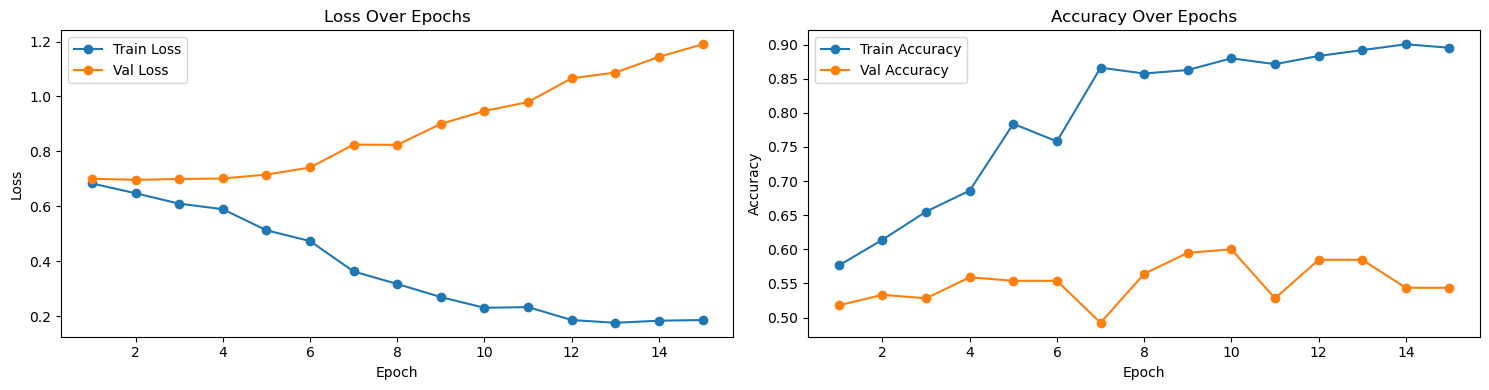

In [19]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Val Loss", marker='o')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs, val_accuracies, label="Val Accuracy", marker='o')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()


VideoMAEForVideoClassification(
  (videomae): VideoMAEModel(
    (embeddings): VideoMAEEmbeddings(
      (patch_embeddings): VideoMAEPatchEmbeddings(
        (projection): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
      )
    )
    (encoder): VideoMAEEncoder(
      (layer): ModuleList(
        (0-11): 12 x VideoMAELayer(
          (attention): VideoMAEAttention(
            (attention): VideoMAESelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
            )
            (output): VideoMAESelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): VideoMAEIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
    

In [21]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

def generate_predictions(model, dataloader):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Predictions"):
            if batch is None:
                continue

            inputs = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=inputs)
            probs = torch.softmax(outputs.logits, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(torch.argmax(probs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_probs), np.array(all_preds), np.array(all_labels)


In [22]:
# Get predictions
probs, preds, labels = generate_predictions(model, test_loader)

test_acc = accuracy_score(labels, preds)
test_f1 = f1_score(labels, preds, average="macro")

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro F1 Score: {test_f1:.4f}")

# Build a DataFrame
df = pd.DataFrame({
    "true_label": labels,
    "pred_label": preds,
    "prob_class_0": probs[:, 0],
    "prob_class_1": probs[:, 1]
})

# Optionally add video filenames
if hasattr(test_dataset, "df") and "video" in test_dataset.df.columns:
    df["video"] = test_dataset.df["video"]

# Save to CSV
df.to_csv("test_predictions.csv", index=False)
print("Saved predictions to test_predictions.csv")


Generating Predictions: 100%|██████████| 49/49 [00:34<00:00,  1.43it/s]

Test Accuracy: 0.5744
Test Macro F1 Score: 0.5736
Saved predictions to test_predictions.csv
